In [1]:
import os
print(os.getcwd())
import sys
sys.path.append('/local/scratch/kchan76/sparse-coarse-operator/')

import torch
from libs.vc_poisson import VarCoeffPoisson
from libs.models import GAT, MultiHeadedAttention2
from libs.utils import *
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)
# !nvidia-smi

/local/scratch/kchan76


/local/scratch/kchan76/sparse-stencil-learning/src/pyamg2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:2


## Define Problem

In [2]:
train_grid_size = 31
k2 = 10 # number of training vectors on level 2 
k3 = 2 # number of training vectors on level 3
kappa = 0.1
option = 'test'
aparams = (kappa,option)
PDE = VarCoeffPoisson(train_grid_size,[k2,k3],aparams=aparams)

## Define and Train Model on Level 2

In [3]:
# set seed
# seed = 4
# print('seed:', seed)
# set_global_seed(seed)

# GAT model config
# hid = 64
# in_head = 4
# out_head = 4
# in_feature = 8
# out_feature = 8
# init = 'xavier normal'
# dropout = .2
# activation = 'relu'

# single_model = False
# softmax_topk = False
# dropout = 0.1
# enforce_pos = True

# GAT_prob = GAT(hid, in_head, out_head, 
#                in_feature=in_feature,
#                out_feature=out_feature,
#                dropout_rate=dropout,
#                init=init,
#                activation=activation)
# GAT_value = GAT(hid, in_head, out_head, 
#                in_feature=in_feature,
#                out_feature=out_feature,
#                dropout_rate=dropout,
#                init=init,
#                activation=activation)
# for p in model.parameters():
#     print(p.requires_grad)

# train model on level 2

# epochs = 1000
# adam_decay_rate = 0
# lr = 1e-3
# lr_decay_rate = 0.2
# lr_decay_step = 500
# softmax_on = False
# single_model = False
# num_nhbr2 = 4

# torch.autograd.set_detect_anomaly(True)
# model_prob2, model_value2 = PDE.train(PDE.A2, 
#                                       PDE.stencils2, 
#                                       PDE.E2, 
#                                       PDE.evec2,
#                                       model_prob_l2, model_value_l2,
#                                       epochs,
#                                       adam_decay_rate, 
#                                       lr, 
#                                       lr_decay_rate, 
#                                       lr_decay_step,
#                                       device,
#                                       single_model=single_model, # double network not implemented yet
#                                       num_nhbr=num_nhbr2,
#                                       softmax_on = softmax_on,
#                                       verbose = True)


In [6]:
seed = 4
print('seed:', seed)
set_global_seed(seed)

h = 8
dhid = 256
epochs = 1510
adam_decay_rate = 0 # adam weight decay
lr = 1e-5 # learning rate
lr_decay_rate = .5 # learning rate decay
lr_decay_step = 500 # learning rate decay step size
dropout = 0.1
init = 'xavier normal' # "<name> <distribution>" name={'xavier', 'kaiming'} distribution={'uniform', 'normal'}

model_prob_l2 = MultiHeadedAttention2(h ,dhid, init=init, dropout=dropout)
model_value_l2 = MultiHeadedAttention2(h, dhid, init=init, dropout=dropout)

single_model = False
softmax_topk = False
# enforce_pos = True

epochs = 500
adam_decay_rate = 0
lr = 1e-5
lr_decay_rate = 0.5
lr_decay_step = 250
softmax_on = False
single_model = False
num_nhbr2 = 4

torch.autograd.set_detect_anomaly(True)
model_probl2, model_valuel2 = PDE.train_attn(PDE.A2, 
                                      PDE.stencils2, 
                                      PDE.evec2,
                                      model_prob_l2, 
                                      model_value_l2,
                                      epochs,
                                      adam_decay_rate, 
                                      lr, 
                                      lr_decay_rate, 
                                      lr_decay_step,
                                      device,
                                      single_model=single_model, # double network not implemented yet
                                      num_nhbr=num_nhbr2,
                                      softmax_on = softmax_on,
                                      verbose = True)

seed: 4
 epoch:  0  loss:  tensor(0.0869, device='cuda:2', dtype=torch.float64, grad_fn=<DivBackward0>)
 epoch:  100  loss:  tensor(0.0441, device='cuda:2', dtype=torch.float64, grad_fn=<DivBackward0>)
 epoch:  200  loss:  tensor(0.0420, device='cuda:2', dtype=torch.float64, grad_fn=<DivBackward0>)
 epoch:  300  loss:  tensor(0.0436, device='cuda:2', dtype=torch.float64, grad_fn=<DivBackward0>)
 epoch:  400  loss:  tensor(0.0435, device='cuda:2', dtype=torch.float64, grad_fn=<DivBackward0>)
 epoch:  499  loss:  tensor(0.0435, device='cuda:2', dtype=torch.float64, grad_fn=<DivBackward0>)


## Test Model on Level 2

In [8]:
models = {}
if single_model:
    models['level2'] = model_probl2
else:
    models['level2'] = model_probl2, model_valuel2
test_grid_size = 63
accel = None
accel = 'gmres'
max_levels = 2
maxits = 100
tol = 1e-30
softmax_on = False
attention = True
_,_,xs,xl,ress,resl = PDE.test_model(models,
                                     test_grid_size,
                                     device,
                                     top_accel = accel,
                                     max_levels = max_levels, 
                                     tol = tol,
                                     maxits = maxits,
                                     num_nhbr = num_nhbr2,
                                     softmax_on = softmax_on,
                                     single_model =single_model,
                                     attention=attention,
                                     verbose = True)
print(ress[-1])
print(resl)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

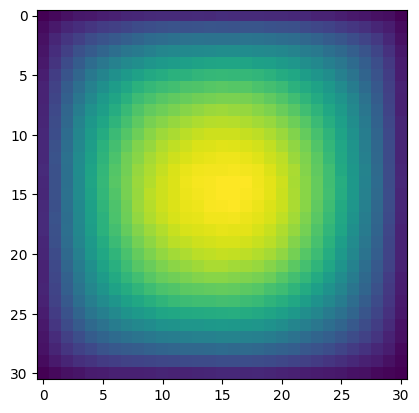

In [6]:
import matplotlib.pyplot as plt 
plt.imshow(xs.reshape(test_grid_size,test_grid_size))

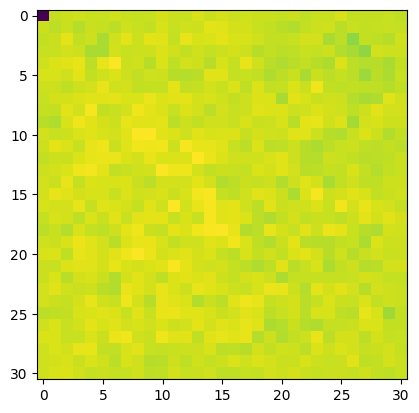

In [7]:
plt.imshow(xl.reshape(test_grid_size,test_grid_size))

In [ ]:
ones = torch.ones(4)
out = torch.zeros(8,4)
torch.eye(8,4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [ ]:
torch.diag(torch.tensor([1,1,1,1]),diagonal=-3)[:-1]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]])